# House prices

Kairos (April 2018)

## Description
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

## Data
79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa.

## Challenge
Predicting the final price of each home.

## Method
We'll use Tensorflow as out method to develop the project.

## First Steps with Tensorflow
This is an introductory notebook, intended to illustrate some fundamental ML concepts using TensorFlow.

In this notebook, we'll be creating a linear regression model to predict final price of each house based on one input feature.

## 1. Set Up
In this first cell, we'll load the necessary libraries.

In [11]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

## 2. Load our data set
Next, we'll load our data set. This file has been created after cleaning the training dataset. http://localhost:8888/notebooks/Houses%20prices%20Iowa/0.House_prices_preparing_dataset_train.ipynb

In [12]:
housing_dataframe = pd.read_csv("input/cleaned_houses_prices_train.csv", sep=",")

## 2. Random the data
We'll randomize the data, just to be sure not to get any pathological ordering effects that might harm the performance of Stochastic Gradient Descent. Additionally, we scale "SalePrice" to be in units of thousands, so it can be learned a little more easily with learning rates in a range that we usually use.

In [13]:
housing_dataframe = housing_dataframe.reindex(
    np.random.permutation(housing_dataframe.index))
housing_dataframe["SalePrice"] /= 1000.0
housing_dataframe

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Foundation,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
594,597,70,3600,6,7,1910,1993,0.0,0,0,...,1,0,0,1,2,1,0,1,0,0
899,903,60,7875,7,5,2003,2003,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
486,488,20,12243,5,6,1971,1971,0.0,998,0,...,1,0,1,0,0,1,0,0,0,0
189,190,120,4923,8,5,2001,2002,0.0,1153,0,...,0,0,0,0,0,2,0,0,0,0
1254,1262,20,9600,5,6,1956,1956,0.0,504,0,...,1,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,23,20,9742,8,5,2002,2002,281.0,0,0,...,0,0,0,0,0,0,0,0,0,0
297,299,60,11700,6,6,1968,1968,365.0,384,175,...,1,0,1,0,0,1,0,0,0,0
1433,1443,60,11003,10,5,2008,2008,160.0,765,0,...,0,0,0,0,0,2,0,0,0,0
1339,1348,20,15306,8,5,2006,2007,100.0,80,0,...,0,0,0,0,0,0,0,0,1,2


## 3. Examine the data
It's a good idea to get to know your data a little bit before you work with it.
We'll print out a quick summary of a few useful statistics on each column.
This will include things like mean, standard deviation, max, min, and various quantiles.

In [14]:
housing_dataframe.describe()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Foundation,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
count,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,...,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0
mean,729.4,56.9,10507.8,6.1,5.6,1971.1,1984.8,103.8,442.3,46.8,...,0.7,0.0,0.9,0.1,0.2,0.7,0.2,0.1,0.2,0.3
std,421.7,42.4,9993.0,1.4,1.1,30.2,20.7,181.1,455.4,161.8,...,0.8,0.3,1.0,0.2,0.5,0.7,0.7,0.4,0.8,0.9
min,1.0,20.0,1300.0,1.0,1.0,1872.0,1950.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,364.5,20.0,7537.5,5.0,5.0,1954.0,1966.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,729.0,50.0,9477.0,6.0,5.0,1972.0,1993.0,0.0,381.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
75%,1094.5,70.0,11600.0,7.0,6.0,2000.0,2004.0,166.0,707.0,0.0,...,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
max,1460.0,190.0,215245.0,10.0,9.0,2010.0,2010.0,1600.0,5644.0,1474.0,...,5.0,5.0,4.0,1.0,4.0,3.0,6.0,2.0,8.0,5.0


## 4. Build the first model
In this exercise, we'll be trying to predict "SalePrice". It will be our label (sometimes also called a target). We'll use "TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)" as our input feature.

To train our model, we'll use the LinearRegressor interface provided by the TensorFlow contrib.learn library. This library takes care of a lot of the plumbing, and exposes a convenient way to interact with data, training, and evaluation.

First, we define the input feature, the target, and create the LinearRegressor object.


### Define feature 
To start, we're going to use just one numeric input feature, TotRmsAbvGrd. The following code pulls the TotRmsAbvGrd data from our housing_dataframe and defines the feature column using numeric_column, which specifies its data is numeric:

In [15]:
# # Define the input feature: TotRmsAbvGrd
my_feature = housing_dataframe[["TotRmsAbvGrd"]]
# Configure a numeric feature column for total_rooms.
feature_columns = [tf.feature_column.numeric_column("TotRmsAbvGrd")]

NOTE: The shape of our TotRmsAbvGrd data is a one-dimensional array (a list of the total number of rooms for each block). This is the default shape for numeric_column, so we don't have to pass it as an argument.

### Define the target

In [16]:
# Define the label.
targets = housing_dataframe["SalePrice"]

###  Configure the LinearRegressor
Next, we'll configure a linear regression model using LinearRegressor. We'll train this model using the GradientDescentOptimizer, which implements Mini-Batch Stochastic Gradient Descent (SGD). The learning_rate argument controls the size of the gradient step.

NOTE: To be safe, we also apply gradient clipping to our optimizer via clip_gradients_by_norm. Gradient clipping ensures the magnitude of the gradients do not become too large during training, which can cause gradient descent to fail.

In [17]:
# Use gradient descent as the optimizer for training the model.
my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)

## 5. Define the Input Function
To import our housing data into our LinearRegressor, we need to define an input function, which instructs TensorFlow how to preprocess the data, as well as how to batch, shuffle, and repeat it during model training.

First, we'll convert our pandas feature data into a dict of NumPy arrays. We can then use the TensorFlow Dataset API to construct a dataset object from our data, and then break our data into batches of batch_size, to be repeated for the specified number of epochs (num_epochs).

NOTE: When the default value of num_epochs=None is passed to repeat(), the input data will be repeated indefinitely.

Next, if shuffle is set to True, we'll shuffle the data so that it's passed to the model randomly during training. The buffer_size argument specifies the size of the dataset from which shuffle will randomly sample.

Finally, our input function constructs an iterator for the dataset and returns the next batch of data to the LinearRegressor.

In [18]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
  
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

NOTE: We'll continue to use this same input function in later exercises. For more detailed documentation of input functions and the Dataset API, see the TensorFlow Programmer's Guide.

## 6. Train the model
We can now call train() on our linear_regressor to train the model. We'll wrap my_input_fn in a lambda so we can pass in my_feature and target as arguments (see this TensorFlow input function tutorial for more details), and to start, we'll train for 100 steps.

In [19]:
_  = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps=100
)

## 7. Evaluate the Model
Let's make predictions on that training data, to see how well we fit the training data.

NOTE: Training error measures how well your model fits the training data, but it does not measure how well your model generalizes to new data. In later exercises, you'll explore how to split your data to evaluate your model's ability to generalize.

In [20]:
# Create an input function for predictions.
# Note: Since we're making just one prediction for each example, we don't 
# need to repeat or shuffle the data here.
prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

# Call predict() on the linear_regressor to make predictions.
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

# Format predictions as a NumPy array, so we can calculate error metrics.
predictions = np.array([item['predictions'][0] for item in predictions])

# Print Mean Squared Error and Root Mean Squared Error.
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print "Mean Squared Error (on training data): %0.3f" % mean_squared_error
print "Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error

Mean Squared Error (on training data): 38911.019
Root Mean Squared Error (on training data): 197.259


Is this a good model? How would you judge how large this error is?

Mean Squared Error (MSE) can be hard to interpret, so we often look at Root Mean Squared Error (RMSE) instead. A nice property of RMSE is that it can be interpreted on the same scale as the original targets.

Let's compare the RMSE to the difference of the min and max of our targets:

In [22]:
min_house_value = housing_dataframe["TotRmsAbvGrd"].min()
max_house_value = housing_dataframe["TotRmsAbvGrd"].max()
min_max_difference = max_house_value - min_house_value

print "Min. TotRmsAbvGrd Value: %0.3f" % min_house_value
print "Max. TotRmsAbvGrd Value: %0.3f" % max_house_value
print "Difference between Min. and Max.: %0.3f" % min_max_difference
print "Root Mean Squared Error: %0.3f" % root_mean_squared_error

Min. TotRmsAbvGrd Value: 2.000
Max. TotRmsAbvGrd Value: 14.000
Difference between Min. and Max.: 12.000
Root Mean Squared Error: 197.259


Our error spans nearly half the range of the target values. Can we do better?

This is the question that nags at every model developer. Let's develop some basic strategies to reduce model error.

The first thing we can do is take a look at how well our predictions match our targets, in terms of overall summary statistics.

In [23]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,1451.0,1451.0
mean,0.0,180.6
std,0.0,79.3
min,0.0,34.9
25%,0.0,129.9
50%,0.0,162.5
75%,0.0,214.0
max,0.0,755.0


Okay, maybe this information is helpful. How does the mean value compare to the model's RMSE? How about the various quantiles?

We can also visualize the data and the line we've learned. Recall that linear regression on a single feature can be drawn as a line mapping input x to output y.

First, we'll get a uniform random sample of the data so we can make a readable scatter plot.

In [24]:
sample = housing_dataframe.sample(n=300)

Next, we'll plot the line we've learned, drawing from the model's bias term and feature weight, together with the scatter plot. The line will show up red.

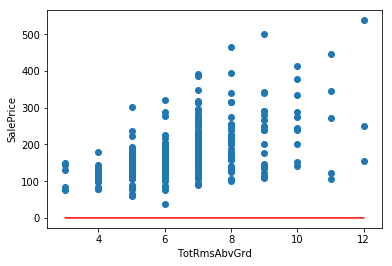

In [26]:
# Get the min and max total_rooms values.
x_0 = sample["TotRmsAbvGrd"].min()
x_1 = sample["TotRmsAbvGrd"].max()

# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/TotRmsAbvGrd/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Label the graph axes.
plt.ylabel("SalePrice")
plt.xlabel("TotRmsAbvGrd")

# Plot a scatter plot from our data sample.
plt.scatter(sample["TotRmsAbvGrd"], sample["SalePrice"])

# Display graph.
plt.show()

This initial line looks way off. See if you can look back at the summary stats and see the same information encoded there.

Together, these initial sanity checks suggest we may be able to find a much better line.

# Tweak the Model Hyperparameters
For this exercise, we've put all the above code in a single function for convenience. You can call the function with different parameters to see the effect.

In this function, we'll proceed in 10 evenly divided periods so that we can observe the model improvement at each period.

For each period, we'll compute and graph training loss. This may help you judge when a model is converged, or if it needs more iterations.

We'll also plot the feature weight and bias term values learned by the model over time. This is another way to see how things converge.

In [32]:
def train_model(learning_rate, steps, batch_size, input_feature="TotRmsAbvGrd"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = housing_dataframe[[my_feature]]
  my_label = "SalePrice"
  targets = housing_dataframe[my_label]

  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Create input functions.
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print "Training model..."
  print "RMSE (on training data):"
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print "  period %02d : %0.2f" % (period, root_mean_squared_error)
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print "Model training finished."

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print "Final RMSE (on training data): %0.2f" % root_mean_squared_error

## Task 1: Achieve an RMSE of 180 or Below
Tweak the model hyperparameters to improve loss and better match the target distribution. If, after 5 minutes or so, you're having trouble beating a RMSE of 180, check the solution for a possible combination.

Training model...
RMSE (on training data):
  period 00 : 165.77
  period 01 : 136.03
  period 02 : 108.36
  period 03 : 87.31
  period 04 : 77.52
  period 05 : 72.23
  period 06 : 69.92
  period 07 : 67.78
  period 08 : 67.33
  period 09 : 67.64
Model training finished.


,predictions,targets
count,1451.0,1451.0
mean,170.8,180.6
std,41.6,79.3
min,55.3,34.9
25%,132.0,129.9
50%,157.6,162.5
75%,183.2,214.0
max,362.1,755.0


Final RMSE (on training data): 67.64


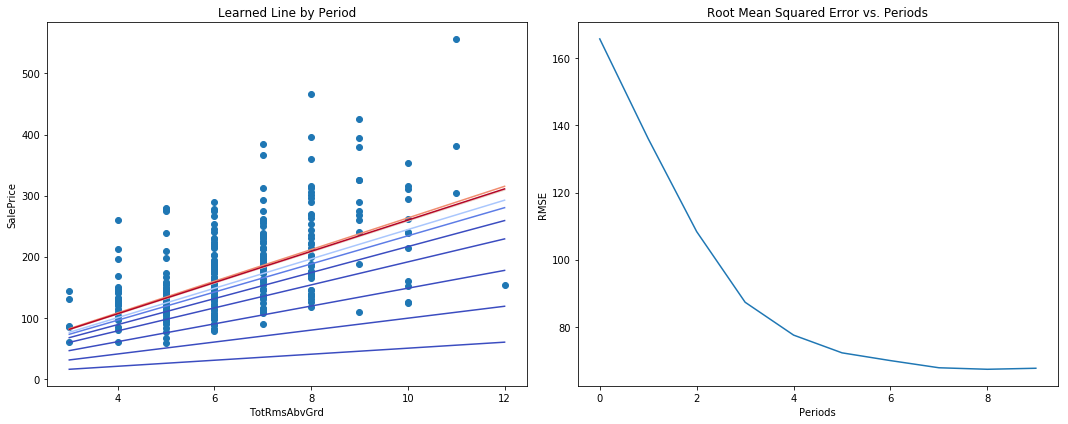

In [33]:
train_model(
    learning_rate=0.01,
    steps=1000,
    batch_size=1
)

### Is there a standard method for tuning the model?
This is a commonly asked question. The short answer is that the effects of different hyperparameters is data dependent. So there are no hard and fast rules; you'll need to run tests on your data.

Here are a few rules of thumb that may help guide you:

- Training error should steadily decrease, steeply at first, and should eventually plateau as training converges.
- If the training has not converged, try running it for longer.
- If the training error decreases too slowly, increasing the learning rate may help it decrease faster.
    - But sometimes the exact opposite may happen if the learning rate is too high.
- If the training error varies wildly, try decreasing the learning rate.
- Lower learning rate plus larger number of steps or larger batch size is often a good combination.
- Very small batch sizes can also cause instability. First try larger values like 100 or 1000, and decrease until you see degradation.

Again, never go strictly by these rules of thumb, because the effects are data dependent. Always experiment and verify.

## Task 2: Try a different feature.
See if you can do any better by replacing the "TotRmsAbvGrd" feature with the "LotArea" feature.


Training model...
RMSE (on training data):
  period 00 : 197.22
  period 01 : 197.12
  period 02 : 196.92
  period 03 : 196.78
  period 04 : 196.63
  period 05 : 196.56
  period 06 : 196.39
  period 07 : 196.14
  period 08 : 196.12
  period 09 : 196.09
Model training finished.


,predictions,targets
count,1451.0,1451.0
mean,1.2,180.6
std,0.6,79.3
min,0.7,34.9
25%,1.0,129.9
50%,1.2,162.5
75%,1.3,214.0
max,12.7,755.0


Final RMSE (on training data): 196.09


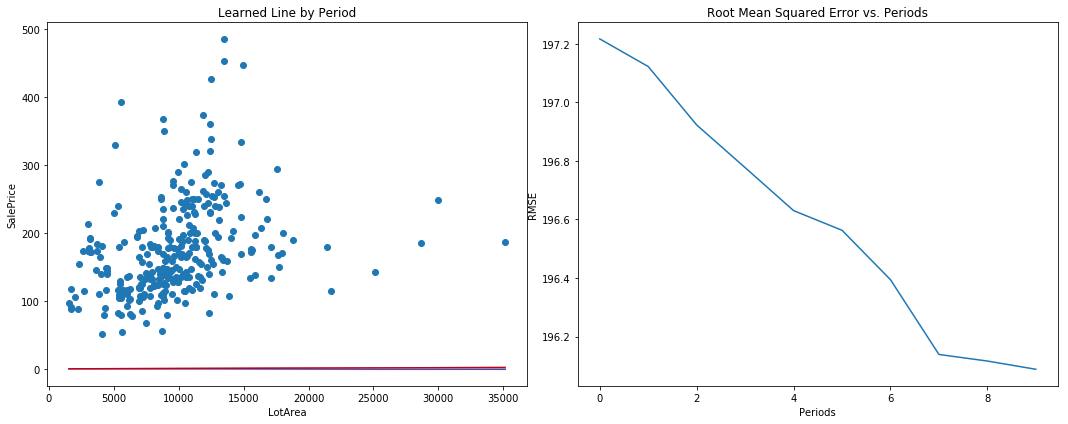

In [34]:
train_model(
    learning_rate=0.8,
    steps=10000,
    batch_size=500,
    input_feature="LotArea"
)